This is taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and adapted for my needs:

 - uses resnet-50 not resnet-18
 - uses tensorboard for training outputs
 - uses custom data classes as written

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

#my class
import my_vision

cudnn.benchmark = True
plt.ion()   # interactive mode

Load data, specify some transformations - not reszing as I've done that already

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'images/clean_image_data'
image_dataset = my_vision.classification_dataset("training_data.csv",data_dir,data_transforms['train'])

image_datasets = dict()
image_datasets['train'],image_datasets['val'], image_datasets['test'] = torch.utils.data.random_split(image_dataset,[0.7,0.15,0.15])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualise some images - check we're on the right track

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))



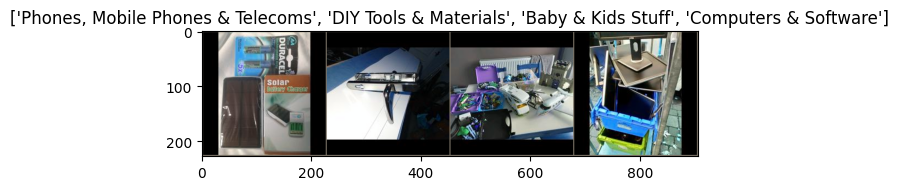

In [4]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[image_dataset.human_category_label(str(x.item()))for x in classes])


Looks OK!

Model training definition - taken direct from tutorial

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #outputs for tensorboard
                    writer.add_scalar("Loss/train", loss, epoch)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    writer.close()
    
    return model

Validation code - again from tutorial

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {image_dataset.human_category_label(str(preds[j].item()))}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Set up a pretrained model

In [7]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 13.

model_ft.fc = nn.Linear(num_ftrs,  13)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Then finetune it:

In [7]:
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1772 Acc: 0.3071
val Loss: 2.0280 Acc: 0.4270

Epoch 1/24
----------
train Loss: 1.8465 Acc: 0.4132
val Loss: 1.8041 Acc: 0.4694

Epoch 2/24
----------
train Loss: 1.6557 Acc: 0.4762
val Loss: 1.7346 Acc: 0.5036

Epoch 3/24
----------
train Loss: 1.4921 Acc: 0.5255
val Loss: 1.7875 Acc: 0.5020

Epoch 4/24
----------
train Loss: 1.3336 Acc: 0.5751
val Loss: 1.9040 Acc: 0.5079

Epoch 5/24
----------
train Loss: 1.2188 Acc: 0.6140
val Loss: 2.0123 Acc: 0.4778

Epoch 6/24
----------
train Loss: 1.0824 Acc: 0.6577
val Loss: 2.0536 Acc: 0.4710

Epoch 7/24
----------
train Loss: 0.5890 Acc: 0.8235
val Loss: 1.8718 Acc: 0.5611

Epoch 8/24
----------
train Loss: 0.4021 Acc: 0.8776
val Loss: 1.9108 Acc: 0.5603

Epoch 9/24
----------
train Loss: 0.3261 Acc: 0.9042
val Loss: 1.9903 Acc: 0.5575

Epoch 10/24
----------
train Loss: 0.2533 Acc: 0.9242
val Loss: 1.9620 Acc: 0.5611

Epoch 11/24
----------
train Loss: 0.2131 Acc: 0.9403
val Loss: 2.0276 Acc: 0.5560

Ep

Phew, done

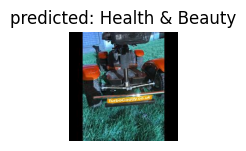

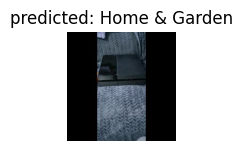

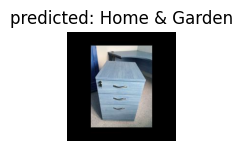

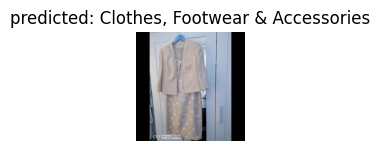

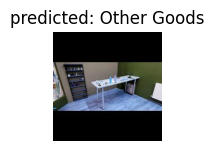

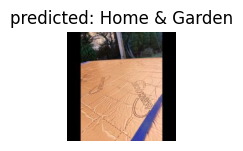

In [14]:
visualize_model(model_ft)

ALternatively: ConvNet as fixed feature extractor

In [8]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 13)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train this alternative model:

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2066 Acc: 0.2955
val Loss: 1.9198 Acc: 0.3956

Epoch 1/24
----------
train Loss: 2.0733 Acc: 0.3505
val Loss: 1.8733 Acc: 0.4381

Epoch 2/24
----------
train Loss: 1.9961 Acc: 0.3766
val Loss: 1.7246 Acc: 0.4694

Epoch 3/24
----------
train Loss: 1.9830 Acc: 0.3829
val Loss: 1.9337 Acc: 0.4353

Epoch 4/24
----------
train Loss: 1.9495 Acc: 0.3842
val Loss: 1.9166 Acc: 0.4758

Epoch 5/24
----------
train Loss: 1.9348 Acc: 0.3954
val Loss: 1.8898 Acc: 0.4706

Epoch 6/24
----------
train Loss: 1.9465 Acc: 0.3924
val Loss: 1.7821 Acc: 0.4702

Epoch 7/24
----------
train Loss: 1.6972 Acc: 0.4583
val Loss: 1.6595 Acc: 0.4861

Epoch 8/24
----------
train Loss: 1.6904 Acc: 0.4548
val Loss: 1.6784 Acc: 0.4861

Epoch 9/24
----------
train Loss: 1.6793 Acc: 0.4555
val Loss: 1.6341 Acc: 0.4956

Epoch 10/24
----------
train Loss: 1.6691 Acc: 0.4628
val Loss: 1.6514 Acc: 0.4897

Epoch 11/24
----------
train Loss: 1.6645 Acc: 0.4582
val Loss: 1.6813 Acc: 0.4873

Ep

Visualise new model

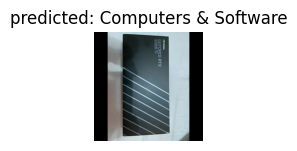

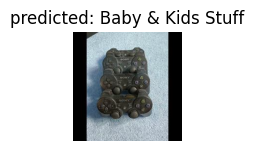

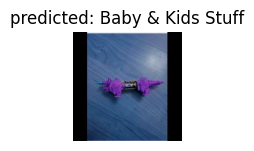

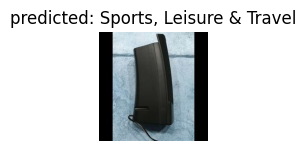

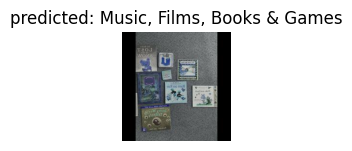

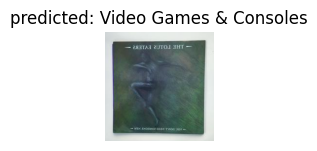

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()